In [1]:
import pandas as pd
import numpy as np
import random
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# path = "./train/"
# imgs = os.listdir("./train/")
# for imgName in random.sample(imgs,int(len(imgs)*0.2)):
#     relPath = path + imgName
#     shutil.move(relPath, "./validation/"+imgName)

In [3]:
trainImgPath = "C:/Users/90507/Desktop/blm5113hw/HW2/train/"
validationImgPath = "C:/Users/90507/Desktop/blm5113hw/HW2/validation/"
testImgPath = "C:/Users/90507/Desktop/blm5113hw/HW2/test2/"

Annotations = "C:/Users/90507/Desktop/blm5113hw/HW2/trainLabels.csv"
testAnnotations = "C:/Users/90507/Desktop/blm5113hw/HW2/testLabels.csv"

In [4]:
transform = transforms.Compose([transforms.PILToTensor()])

In [5]:
class customDataset(Dataset):
    def __init__(self, imgPath, annotationsFile, transform=None):
        self.imgPath = imgPath
        self.imgNames = os.listdir(imgPath)
        self.csv = pd.read_csv(annotationsFile)
        self.id = self.csv["id"]
        self.annotations = pd.get_dummies(self.csv["label"])
        self.transform = transform
        self.classNames = self.annotations.columns.tolist()

    def __len__(self):
        return len(self.imgNames)

    def __getitem__(self, idx):
        imgName = self.imgNames[idx]
        imgPath = os.path.join(self.imgPath, imgName)
        image = Image.open(imgPath)

        if self.transform:
            image = self.transform(image)

        image = image / 255.0

        label = self.annotations.loc[self.id==int(imgName.split(".")[0])]
        return image, label.to_numpy()

In [6]:
trainingData = customDataset(trainImgPath, Annotations, transform)
validationData = customDataset(validationImgPath, Annotations, transform)
testData = customDataset(testImgPath, testAnnotations, transform)

trainDataloader = DataLoader(trainingData, batch_size=256, shuffle=True)
validationDataloader = DataLoader(validationData, batch_size=256, shuffle=True)
testDataloader = DataLoader(testData, batch_size=30, shuffle=False)

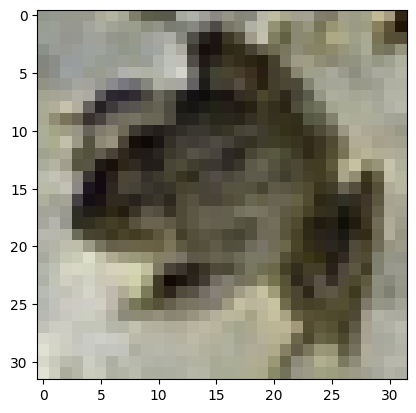

frog


In [118]:
i = 11
trainFeatures, trainLabels = trainingData[i]
img = trainFeatures.squeeze().permute((1, 2, 0))
label = trainLabels.argmax()
plt.imshow(img)
plt.show()
print(trainingData.classNames[label])

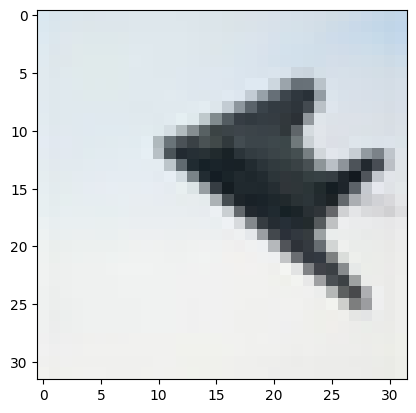

airplane


In [8]:
trainFeatures, trainLabels = next(iter(trainDataloader))
img = trainFeatures[0].squeeze().permute((1, 2, 0))
label = trainLabels[0].argmax()
plt.imshow(img)
plt.show()
print(trainingData.classNames[label])

In [9]:
trainFeatures.shape

torch.Size([256, 3, 32, 32])

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(26*26*64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
net = Net().to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [11]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def accuracy(outputs, labels):
    with torch.no_grad():
        eq = torch.eq(outputs.argmax(1).detach().to("cpu"), labels.argmax(2).squeeze())
        return eq.sum()/eq.numel()

In [13]:
lossTrainHist = []
lossValidationHist = []
accuracyTrainHist = []
accuracyValidationHist = []
minLoss = float('inf')

for epoch in range(10):
    print("epoch",epoch+1)
    
    runningTrainLoss = 0.0
    runningValidationLoss = 0.0
    
    net.train()
    for i, data in enumerate(trainDataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs.to("cuda"))
        
        lossTrain = criterion(outputs, labels.argmax(2).squeeze().to("cuda"))
        lossTrain.backward()
        optimizer.step()
        
        runningTrainLoss += lossTrain.item()
        accuracyTrainHist.append(accuracy(outputs, labels))
        
    lossTrainHist.append(runningTrainLoss/(i+1))
    
    net.eval()
    for i, data in enumerate(validationDataloader, 0):
        inputs, labels = data
        with torch.no_grad():
            outputs = net(inputs.to("cuda"))

        lossValidation = criterion(outputs, labels.argmax(2).squeeze().to("cuda"))
        
        runningValidationLoss += lossValidation.item()
        accuracyValidationHist.append(accuracy(outputs, labels))
        
    lossValidationHist.append(runningValidationLoss/(i+1))
    
    if minLoss>lossValidationHist[epoch]:
        minLoss = lossValidationHist[epoch]
        bestWeights1 = net.state_dict().copy()
        epochSave = epoch

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10


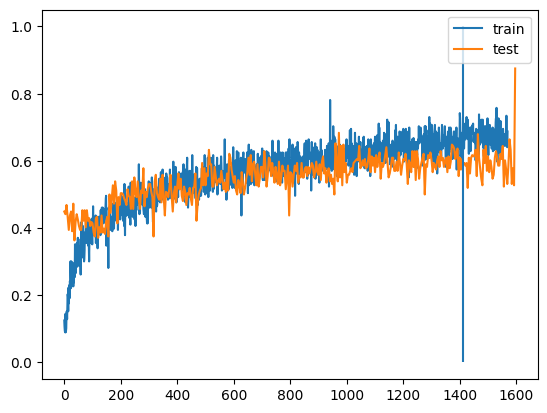

9


In [14]:
plt.plot(np.arange(len(accuracyTrainHist)),accuracyTrainHist)
plt.plot(np.arange(len(accuracyValidationHist))*4,accuracyValidationHist)
plt.vlines(len(accuracyTrainHist)*epochSave/10,0,1)
plt.legend(["train","test"])
plt.show()
print(epochSave)

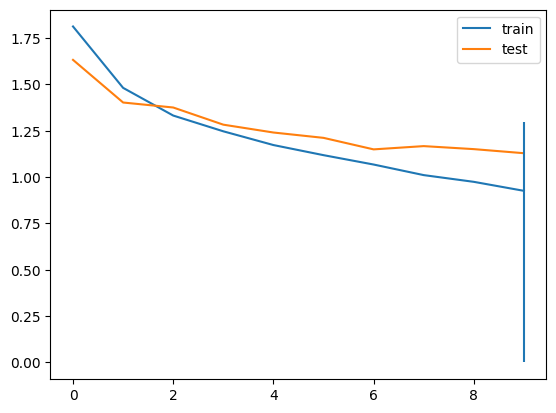

In [16]:
plt.plot(range(len(lossTrainHist)),lossTrainHist)
plt.plot(range(len(lossValidationHist)),lossValidationHist)
plt.vlines(epochSave,0,1.3)
plt.legend(["train","test"])
plt.show()

In [17]:
net.load_state_dict(bestWeights1)
net.to("cpu").eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=43264, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

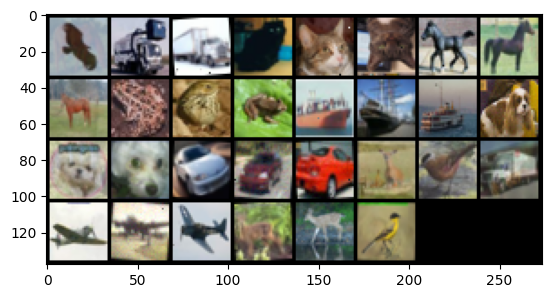

['bird', 'truck', 'truck', 'deer', 'cat', 'cat', 'horse', 'horse', 'horse', 'frog', 'frog', 'frog', 'ship', 'truck', 'ship', 'dog', 'horse', 'dog', 'automobile', 'automobile', 'automobile', 'bird', 'frog', 'truck', 'airplane', 'airplane', 'airplane', 'deer', 'bird', 'bird']


In [18]:
inputs, labels = next(iter(testDataloader))
with torch.no_grad():
    outputs = net(inputs)

imshow(torchvision.utils.make_grid(inputs))
label = labels.argmax()
print([trainingData.classNames[i] for i in outputs.argmax(1).squeeze()])

In [19]:
accuracy(outputs, labels)

tensor(0.6333)

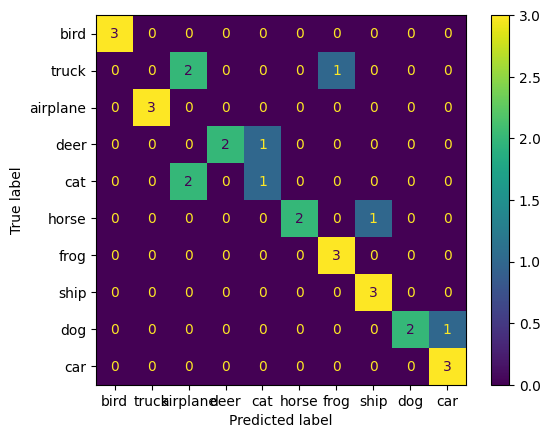

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(labels.argmax(2).cpu().numpy(),outputs.argmax(1).unsqueeze(1).cpu().numpy(),labels=list(range(10))),
                              display_labels=testData.csv["label"][0:-1:3].to_list())

disp.plot()

plt.show()

# CUSTOM

In [21]:
class customNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv1Bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv2Bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 1)
        self.conv3Bn = nn.BatchNorm2d(128)
        self.maxpool = nn.MaxPool2d(3)
        self.fc1 = nn.Linear(8*8*128, 128)
        self.fc1Bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv1Bn(x)
        x = F.relu(self.conv2(x))
        x = self.conv2Bn(x)
        x = F.relu(self.conv3(x))
        x = self.conv3Bn(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc1Bn(x)
        x = self.fc2(x)
        return x

In [22]:
net = customNet().to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [23]:
lossTrainHist = []
lossValidationHist = []
accuracyTrainHist = []
accuracyValidationHist = []
minLoss = float('inf')

for epoch in range(10):
    print("epoch",epoch+1)
    
    runningTrainLoss = 0.0
    runningValidationLoss = 0.0
    
    net.train()
    for i, data in enumerate(trainDataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs.to("cuda"))
        
        lossTrain = criterion(outputs, labels.argmax(2).squeeze().to("cuda"))
        lossTrain.backward()
        optimizer.step()
        
        runningTrainLoss += lossTrain.item()
        accuracyTrainHist.append(accuracy(outputs, labels))
        
    lossTrainHist.append(runningTrainLoss/(i+1))
    
    net.eval()
    for i, data in enumerate(validationDataloader, 0):
        inputs, labels = data
        with torch.no_grad():
            outputs = net(inputs.to("cuda"))

        lossValidation = criterion(outputs, labels.argmax(2).squeeze().to("cuda"))
        
        runningValidationLoss += lossValidation.item()
        accuracyValidationHist.append(accuracy(outputs, labels))
        
    lossValidationHist.append(runningValidationLoss/(i+1))
    
    if minLoss>lossValidationHist[epoch]:
        minLoss = lossValidationHist[epoch]
        bestWeights2 = net.state_dict().copy()
        epochSave = epoch

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10


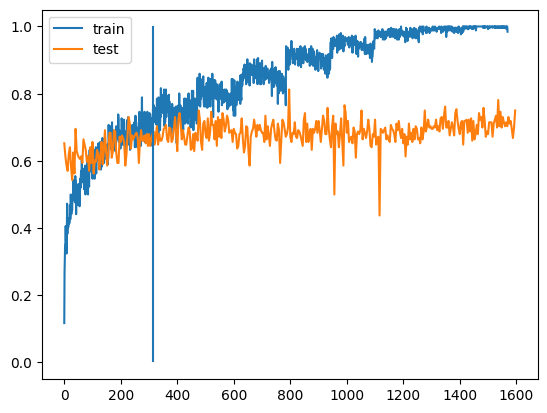

2


In [24]:
plt.plot(np.arange(len(accuracyTrainHist)),accuracyTrainHist)
plt.plot(np.arange(len(accuracyValidationHist))*4,accuracyValidationHist)
plt.vlines(len(accuracyTrainHist)*epochSave/10,0,1)
plt.legend(["train","test"])
plt.show()
print(epochSave)

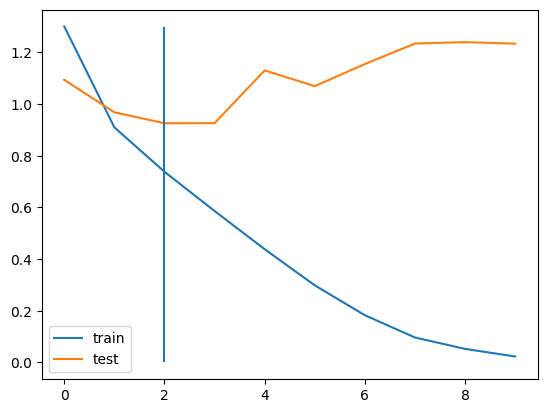

In [25]:
plt.plot(range(len(lossTrainHist)),lossTrainHist)
plt.plot(range(len(lossValidationHist)),lossValidationHist)
plt.vlines(epochSave,0,1.3)
plt.legend(["train","test"])
plt.show()

In [26]:
net.load_state_dict(bestWeights2)
net.to("cpu").eval()

customNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1Bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2Bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv3Bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc1Bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

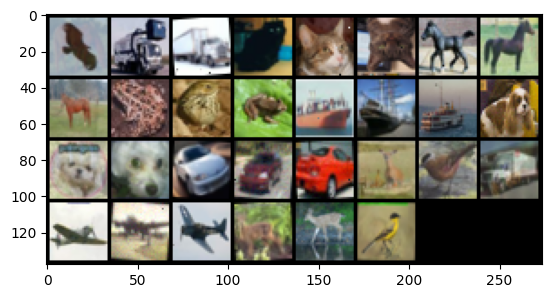

['bird', 'truck', 'truck', 'bird', 'cat', 'deer', 'horse', 'horse', 'horse', 'frog', 'dog', 'frog', 'ship', 'ship', 'ship', 'dog', 'dog', 'dog', 'automobile', 'automobile', 'automobile', 'deer', 'bird', 'truck', 'airplane', 'airplane', 'airplane', 'deer', 'deer', 'bird']


In [27]:
inputs, labels = next(iter(testDataloader))
with torch.no_grad():
    outputs = net(inputs)

imshow(torchvision.utils.make_grid(inputs))
label = labels.argmax()
print([trainingData.classNames[i] for i in outputs.argmax(1).squeeze()])

In [28]:
accuracy(outputs, labels)

tensor(0.7000)

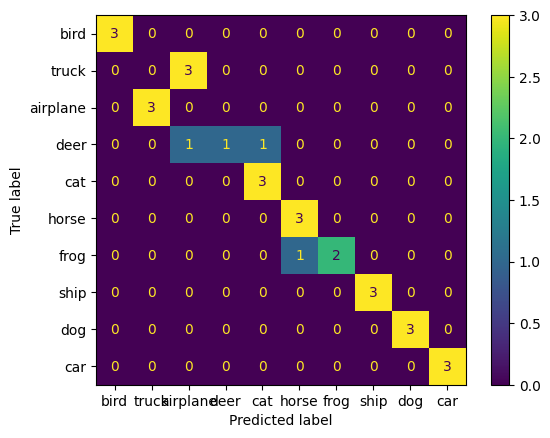

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(labels.argmax(2).cpu().numpy(),outputs.argmax(1).unsqueeze(1).cpu().numpy(),labels=list(range(10))),
                              display_labels=testData.csv["label"][0:-1:3].to_list())

disp.plot()

plt.show()

In [121]:
i=0

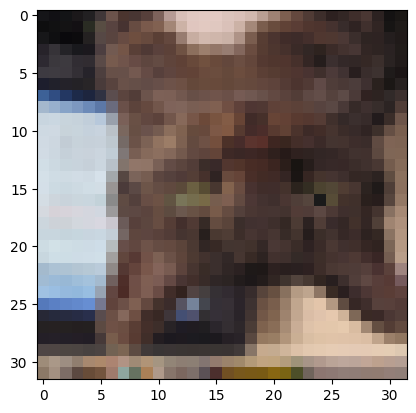

actual : cat , predicted:  deer


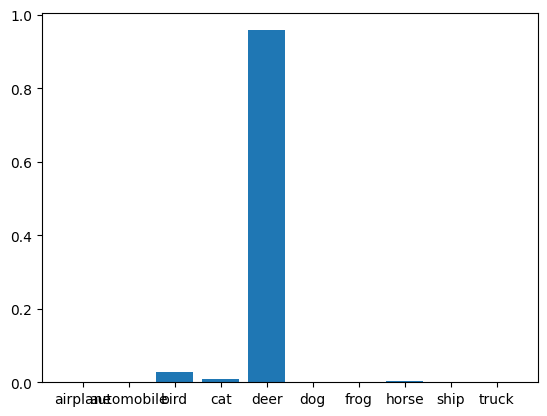

In [126]:
i+=1
inputs, labels = next(iter(testDataloader))
with torch.no_grad():
    outputs = net(inputs[i].unsqueeze(dim=0))

imshow(torchvision.utils.make_grid(inputs[i]))
label = labels[i].argmax()
output = outputs.argmax()
print("actual :", trainingData.classNames[label], ", predicted: ",trainingData.classNames[output])
plt.bar(trainingData.classNames, F.softmax(outputs,dim=1).numpy()[0])
plt.show()